# Refinements - Improved MNIST Classifer

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn
import mindspore.dataset as ds

import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f'MindSpore version is {mindspore.__version__}, running on {mindspore.context.get_context("device_target")}.')

MindSpore version is 1.6.1, running on Ascend.


## DataSet Class

In [3]:
# dataset class

class MnistDataset:
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = np.zeros((10), np.float32)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = np.array(self.data_df.iloc[index,1:].values, dtype=np.float32) / 255.0
        
        # return image data tensor and target tensor
        return image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')


## Load Data

In [4]:
mnist_dataset = MnistDataset('./dataset/mnist/mnist_train.csv')

batch_size = 16
train_dataset = ds.GeneratorDataset(mnist_dataset, column_names=['image', 'label']).batch(batch_size)

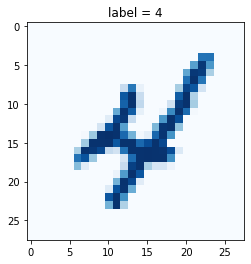

In [5]:
# check data contains images

mnist_dataset.plot_image(9)

In [6]:
# check Dataset class can be accessed by index, returns image values and target

mnist_dataset[100]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

## Neural Network Class

In [7]:
from datetime import datetime
from mindspore.train.callback import Callback

# classifier class

class Classifier(nn.Cell):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(784, 200),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm((200,)),
            
            nn.Dense(200, 10),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02)
        )
        
        # create loss function
        self.loss_function = nn.BCELoss(reduction='mean')
        #self.loss_function = nn.MSELoss()

        # create optimizer
        #self.optimizer = nn.SGD(self.model.trainable_params(), lr=0.01)
        self.optimizer = nn.Adam(self.model.trainable_params())

        self.model_train = mindspore.Model(self.model, loss_fn=self.loss_function, optimizer=self.optimizer)
        
        # accumulator for progress
        self.progress = []
    
    def construct(self, inputs):
        # simply run model
        return self.model(inputs)

    def train(self, epochs, dataset):
        class LossCallback(Callback):
            def __init__(self, progress):
                super().__init__()
                self.progress = progress

            def epoch_begin(self, run_context):
                cb_params = run_context.original_args()
                print(f'{datetime.now()}： start epoch {cb_params.cur_epoch_num} of {epochs}:')
            
            def step_end(self, run_context):
                cb_params = run_context.original_args()
                step_num = cb_params.cur_step_num
                if step_num % 10 == 0:
                    loss = cb_params.net_outputs
                    self.progress.append(loss.asnumpy())
                if step_num % 500 == 0:
                    print(f'{datetime.now()}: counter = {step_num}')

        self.model_train.train(epochs, dataset, callbacks=[LossCallback(self.progress)], dataset_sink_mode=False)
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Train Neural Network

In [8]:
%%time 
# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 3

C.train(epochs, train_dataset)


2022-05-21 14:59:01.394927： start epoch 1 of 3:
2022-05-21 14:59:24.355978: counter = 500
2022-05-21 14:59:29.228760: counter = 1000
2022-05-21 14:59:34.113127: counter = 1500
2022-05-21 14:59:39.032247: counter = 2000
2022-05-21 14:59:43.935840: counter = 2500
2022-05-21 14:59:48.856597: counter = 3000
2022-05-21 14:59:53.772946: counter = 3500
2022-05-21 14:59:56.237741： start epoch 2 of 3:
2022-05-21 14:59:58.699576: counter = 4000
2022-05-21 15:00:03.635948: counter = 4500
2022-05-21 15:00:08.549262: counter = 5000
2022-05-21 15:00:13.456513: counter = 5500
2022-05-21 15:00:18.337543: counter = 6000
2022-05-21 15:00:23.268599: counter = 6500
2022-05-21 15:00:28.185906: counter = 7000
2022-05-21 15:00:33.216882: counter = 7500
2022-05-21 15:00:33.219141： start epoch 3 of 3:
2022-05-21 15:00:38.215610: counter = 8000
2022-05-21 15:00:43.201587: counter = 8500
2022-05-21 15:00:48.214188: counter = 9000
2022-05-21 15:00:53.188263: counter = 9500
2022-05-21 15:00:58.160680: counter = 10

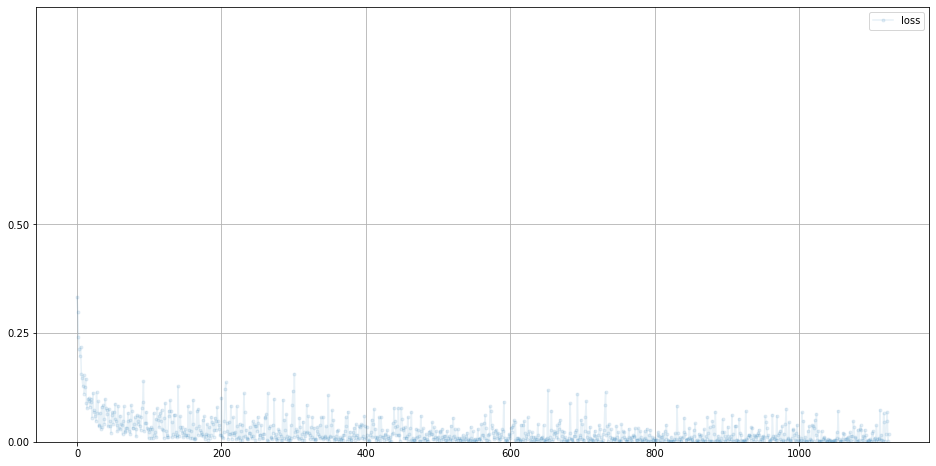

In [9]:
# plot classifier error

C.plot_progress()

## Classification Example

In [10]:
# load MNIST test data

mnist_test_dataset = MnistDataset('./dataset/mnist/mnist_test.csv')
test_dataset = ds.GeneratorDataset(mnist_test_dataset, ['image', 'label']).batch(1)

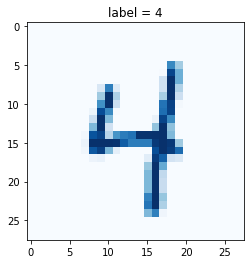

In [11]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

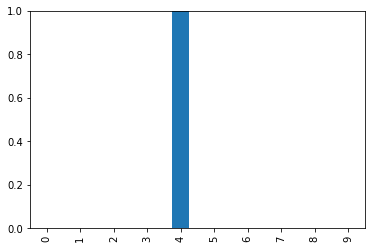

In [12]:
# visualise the answer given by the neural network

image_data = mindspore.ops.ExpandDims()(mindspore.Tensor(mnist_test_dataset[record][0]), 0)

# query from trained network
output = C.construct(image_data)

# plot output tensor
pandas.DataFrame(output[0].asnumpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Classifier Performance

In [13]:
# test trained neural network on training data

score = 0
items = 0

for image_data_tensor, target_tensor in test_dataset:
    target = target_tensor[0].asnumpy()
    answer = C.construct(image_data_tensor)[0].asnumpy()
    if (answer.argmax() == target.argmax()):
        score += 1
    items += 1

print(score, items, score/items)

9755 10000 0.9755
